In [1]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [2]:
anti = 1

L = 5
num_trash = 2

name = "ibmq_ferro-1D-load-AD_simu"
filename = f"data/params_VQE_Ising_L5_anti_1_50x50"
print("filename: ", filename, "notebook name: ", name)

filename:  data/params_VQE_Ising_L5_anti_1_50x50 notebook name:  ibmq_ferro-1D-load-AD_simu


In [3]:
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

In [4]:
device = provider.backend.ibmq_rome
print(device)

ibmq_rome


In [5]:
#backend = device
backend = qiskit.providers.aer.AerSimulator.from_backend(device)

In [6]:
coupling_map = device.configuration().coupling_map
noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [7]:
#aqua_globals.random_seed = seed
qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                         coupling_map=coupling_map, noise_model=noise_model,
                         measurement_error_mitigation_cls= CompleteMeasFitter, 
                         cals_matrix_refresh_period=30  #How often to refresh the calibration matrix in measurement mitigation. in minutes
                                 )

In [8]:
L = 5
anti = 1

VQE_params = np.load(filename + ".npz", allow_pickle=True)
gx_list = VQE_params['gx_list'][::50]
gz_list = VQE_params['gz_list'][::50]
opt_params = VQE_params['opt_params'][::50]

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

mag = QMag(L,anti) #magnetization operator (Qiskit)
Smag = Mag(L,anti) #magnetization operator (numpy)
# the ~ is the adjoint, but also it turns the is_measurement attribute to True
~StateFn(mag)
# state is technically a circuit, that prepares the ground state via VQE circuit
#state.draw() # uncomment to see, but is very long

Qen=np.zeros(len(opt_params), dtype="complex"); Sen=np.zeros(len(opt_params), dtype="complex") #energies
Qmags=np.zeros(len(opt_params), dtype="complex"); Smags=np.zeros(len(opt_params), dtype="complex") #magnetizations

In [9]:
load = True

In [10]:
if load:
    temp = np.load("data/" + name + "_mags-Es.npz",allow_pickle=True)
    Qmags = temp["Qmags"]
    Qen = temp["Qen"]
    Sen = temp["Sen"]
    Smags = temp["Smags"]

In [11]:
verbose = 10 # show every 10 steps
if not load:
    for j in range(len(opt_params)):
        t0 = datetime.datetime.now()
        gx = gx_list[j]
        gz = gz_list[j]
        H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
        state = init_vqe(opt_params[j], L=L)
        meas_outcome = ~StateFn(mag) @ StateFn(state)

        Qmags[j] = CircuitSampler(qi).convert(meas_outcome).eval() #https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit
        #e_outcome = ~StateFn(H) @ StateFn(state)
        #Qen[j] = CircuitSampler(qi).convert(e_outcome).eval()
        
        
        init_state, E, ham = ising_groundstate(L, anti, np.float64(gx), np.float64(gz))
        Sen[j] = E
        Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
        if not j%verbose:
            print(f"{j+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")
    np.savez("data/" + name + "_mags-Es.npz",Qmags=Qmags, Qen=Qen, Sen=Sen, Smags=Smags) # for large parameter space takes quite a while because of the exact diagonalization

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


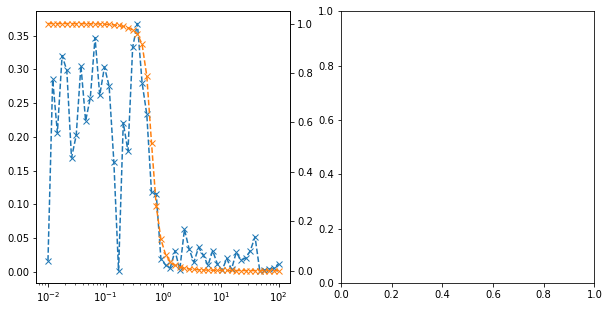

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(gx_list, abs(Qmags),"x--")
ax1 = ax.twinx()
ax1.plot(gx_list, Smags,"x--",color="tab:orange")
ax.set_xscale("log")
ax1.set_xscale("log")


In [29]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

In [24]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()
    for i in range(num_trash):
        circ.ry(thetas[L-i-1], L-i-1)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=5, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=True)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = init_vqe(init_state,L=L) + circ
        else:
            circ.initialize(init_state, qreg)
    return circ

In [15]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [20]:
def calibrate_circuit(L, num_trash,shots=1000):
    qreg = QuantumRegister(L, 'q')
    # obtain calibration matrix
    qubit_list = [L-i-1 for i in range(num_trash)] # only need to calibrate the trash qubits
    circlabel = f'mcal_{datetime.datetime.now()}'
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qreg, circlabel=circlabel)
    cal_job = backend.run(meas_calibs, shots=shots, noise_model=noise_model)
    cal_results = cal_job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel=circlabel)
    print(circlabel, meas_fitter.cal_matrix)
    return meas_fitter

In [25]:
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100, meas_fitter = None):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(tcirc, shots=shots) # , seed_simulator=123, seed_transpiler=234 fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

In [30]:
thetas = np.random.uniform(0, 2*np.pi, 2*L+2)

In [26]:
meas_fitter = calibrate_circuit(L, num_trash)

mcal_2021-05-31 17:25:54.450607 [[0.986 0.026 0.03  0.   ]
 [0.006 0.968 0.    0.025]
 [0.008 0.    0.961 0.039]
 [0.    0.006 0.009 0.936]]


In [27]:
phi = opt_params[0]
raw_counts = run_circuit(thetas, L, num_trash, phi, meas_fitter=None)
mitigated_counts = run_circuit(thetas, L, num_trash, phi, meas_fitter=meas_fitter)

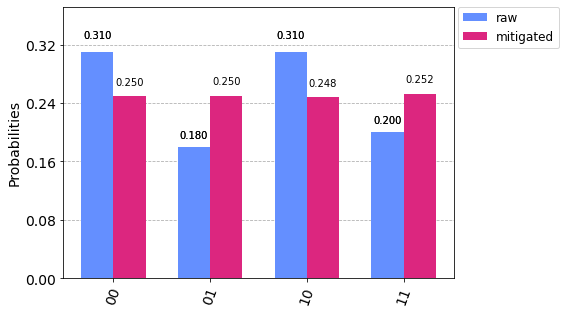

In [28]:
from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [51]:
# translate to Rikes naming
phis = opt_params
gxs = gx_list
gzs = gz_list

In [52]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter = meas_fitter)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         #learning_rate=1e-1,
                         #perturbation=0.4
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [54]:
def run_inference(thetas, shots=1000, L=5):
    points = 50
    J = -1.0
    x,y = np.meshgrid(gx_vals, gz_vals)
    cost = np.zeros((len(gx_vals) * len(gz_vals)))
    Smags = np.zeros((len(gx_vals) * len(gz_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
        t0 = datetime.datetime.now()
        cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots)
        if not i%verbose:
            print(f"{i+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")

    cost = cost.reshape((len(gx_vals), len(gz_vals)))
    return cost

## Run 1

Initial cost: 0.876
Time: 137.27429 sec
(array([ 0.50038857,  2.68570711,  2.52600434,  3.90040466,  6.22013173,
        5.05245138,  3.46689779,  0.92168863, -0.25453373,  6.23804855,
        3.72686995,  3.22739271]), 0.803, 600)


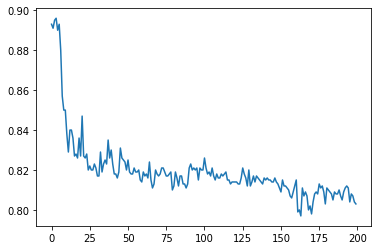

In [55]:
# Training
phys_params = [3]
thetas_opt, loss, accepted = optimize(phys_params, max_iter=200, L=5) #, pick_optimizer="adam")
plt.plot(loss)

In [57]:
# Inference
cost = np.zeros((len(gx_vals)))
shots = 1000
for i,p in enumerate(list(zip(gxs, gzs))):
    t0 = datetime.datetime.now()
    cost[i] = cost_function_single(thetas_opt, L, num_trash, i, shots=shots) # np.random.uniform(0, 2*np.pi, 2*L+2) random parameters to check if training "does" something - result was: with random paremters just get noise, so yes, it "does" something
    if not i%verbose:
        print(f"{i+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")

1 / 50, gx = 100.00, gz = 0.01, time : 0:00:02.132430
11 / 50, gx = 100.00, gz = 0.01, time : 0:00:01.929570
21 / 50, gx = 100.00, gz = 0.01, time : 0:00:01.955270
31 / 50, gx = 100.00, gz = 0.01, time : 0:00:01.878100
41 / 50, gx = 100.00, gz = 0.01, time : 0:00:02.081690


In [58]:
np.savez("data/" + name + "_thetas-loss-cost_run1",cost=cost, thetas=thetas_opt)

In [65]:
gz_list[0]

0.01

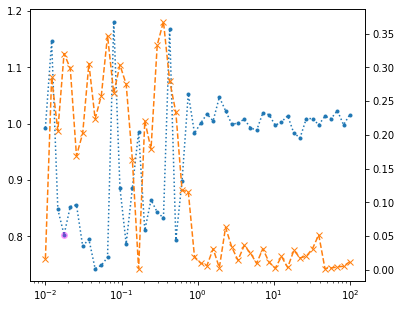

In [77]:
fig, ax = plt.subplots(figsize=(6,5))
cost = np.load("data/" + name + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost"]
ax.plot(gx_list, cost,".:")
ax1 = ax.twinx()
ax1.plot(gx_list, abs(Qmags),"x--", color="tab:orange")
ax.set_xscale("log")
ax1.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")

# Run 2

Initial cost: 1.117
Time: 139.72765 sec
(array([ 2.02683373, -1.47148951,  4.24967798,  4.63364541,  6.30553042,
       -0.98046275,  6.27897051,  0.42679657,  1.72927529,  4.73713061,
       -1.83764598,  0.7992842 ]), 0.785, 600)


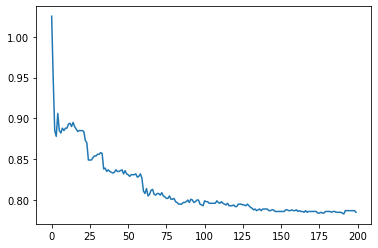

In [78]:
# Training
phys_params = [-2]
thetas_opt, loss, accepted = optimize(phys_params, max_iter=200, L=5) #, pick_optimizer="adam")
plt.plot(loss)

In [79]:
# Inference
cost = np.zeros((len(gx_vals)))
shots = 1000
for i,p in enumerate(list(zip(gxs, gzs))):
    t0 = datetime.datetime.now()
    cost[i] = cost_function_single(thetas_opt, L, num_trash, i, shots=shots) # np.random.uniform(0, 2*np.pi, 2*L+2) random parameters to check if training "does" something - result was: with random paremters just get noise, so yes, it "does" something
    if not i%verbose:
        print(f"{i+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")

1 / 50, gx = 100.00, gz = 0.01, time : 0:00:01.997880
11 / 50, gx = 100.00, gz = 0.01, time : 0:00:02.369010
21 / 50, gx = 100.00, gz = 0.01, time : 0:00:02.362920
31 / 50, gx = 100.00, gz = 0.01, time : 0:00:02.076070
41 / 50, gx = 100.00, gz = 0.01, time : 0:00:02.190850


In [80]:
np.savez("data/" + name + "_thetas-loss-cost_run2",cost=cost, thetas=thetas_opt)

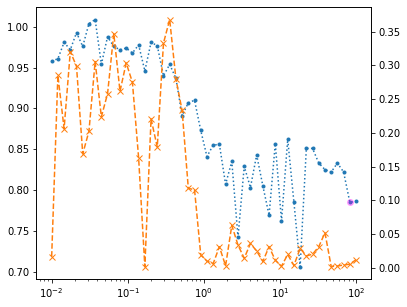

In [81]:
fig, ax = plt.subplots(figsize=(6,5))
cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost"]
ax.plot(gx_list, cost,".:")
ax1 = ax.twinx()
ax1.plot(gx_list, abs(Qmags),"x--", color="tab:orange")
ax.set_xscale("log")
ax1.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")